<h2 style = "color:purple;">Import Libraries</h2>

In [0]:
import numpy as np
from numpy import dstack
import pandas as pd
import tensorflow as tf
import keras
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import sklearn as sk
import sklearn.metrics.pairwise
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import *
from keras import metrics
from keras import backend as K
from pyts.image import RecurrencePlot
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<h2 style = "color:purple;">Data Ingestion</h2>

Ideally, when working with multivariate time series data, it is useful to have the data structured in the format:
** [samples, timesteps, features] ** 
<br>
This is helpful for analysis and is the expectation of deep learning models such as convolutional neural networks and recurrent neural networks.

In [0]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

def load_dataset_2(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	#filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load all train
trainX, trainY = load_dataset('train', 'HARDataset/')
# load all test
testX, testY = load_dataset('test', 'HARDataset/')

## Preliminary Data Analysis

In [0]:
print("trainX[samples,timesteps,features]:",trainX.shape)

trainX[samples,timesteps,features]: (7352, 128, 9)


In [0]:
trainY.shape

(7352, 1)

In [0]:
print("testX[samples,timesteps,features]:",testX.shape)

testX[samples,timesteps,features]: (2947, 128, 9)


In [0]:
testY.shape

(2947, 1)

### Class to label mapping
* 1 -> Walking
* 2 -> Walking Upstairs
* 3 -> Walking Downstairs
* 4 -> Sitting
* 5 -> Standing
* 6 -> Laying

In [0]:
# summarize the balance of classes in an output variable column
def class_breakdown(data):
    # convert the numpy array into a dataframe
    df = pd.DataFrame(data)
    # group data by the class value and calculate the number of rows
    counts = df.groupby(0).size()
    # retrieve raw rows
    counts = counts.values
    # summarize
    summary = []
    for i in range(len(counts)):
        percent = counts[i] / len(df) * 100
        summary.append((i+1, counts[i], percent))
    return summary

In [0]:
# load train file
train_set = load_file('HARDataset/train/y_train.txt')
summary_train_set = class_breakdown(train_set)
# summarize class breakdown
print('Train Dataset')
summary_train_set

Train Dataset


[(1, 1226, 16.675734494015234),
 (2, 1073, 14.594668117519042),
 (3, 986, 13.411316648531013),
 (4, 1286, 17.491838955386292),
 (5, 1374, 18.68879216539717),
 (6, 1407, 19.13764961915125)]

In [0]:
# load test file
test_set = load_file('HARDataset/test/y_test.txt')
summary_test_set = class_breakdown(test_set)
# summarize class breakdown
print('Test Dataset')
summary_test_set

Test Dataset


[(1, 496, 16.830675262979298),
 (2, 471, 15.982354937224297),
 (3, 420, 14.251781472684085),
 (4, 491, 16.661011197828298),
 (5, 532, 18.052256532066508),
 (6, 537, 18.22192059721751)]

<h3 style = "color:blue;">Visualize Class Distribution</h3>

#### Train Set

In [0]:
summary_train_set = np.array(summary_train_set)

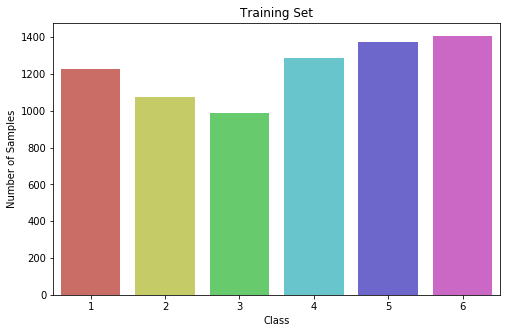

In [0]:
plt.figure(figsize=(8,5))
plt.title("Training Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
sns.barplot(np.array(summary_train_set[:,0],dtype=np.int32),summary_train_set[:,1], palette="hls")
plt.show()

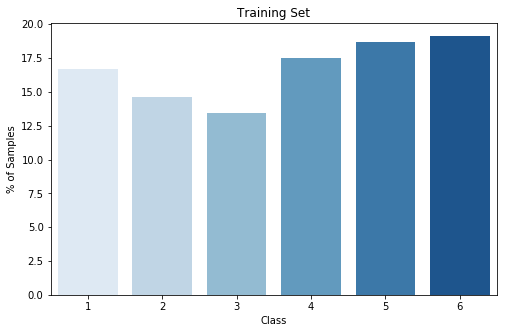

In [0]:
plt.figure(figsize=(8,5))
plt.title("Training Set")
plt.xlabel("Class")
plt.ylabel("% of Samples")
sns.barplot(np.array(summary_train_set[:,0],dtype=np.int32),summary_train_set[:,2], palette="Blues")
plt.show()

#### Test Set

In [0]:
summary_test_set = np.array(summary_test_set)

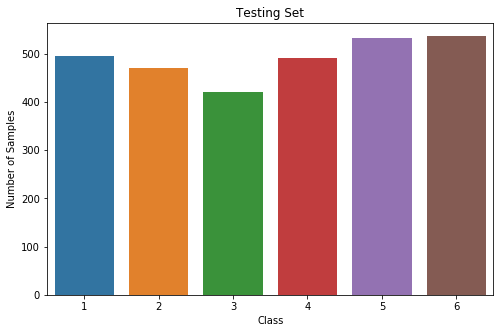

In [0]:
plt.figure(figsize=(8,5))
plt.title("Testing Set")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
sns.barplot(np.array(summary_test_set[:,0],dtype=np.int32),summary_test_set[:,1])
plt.show()

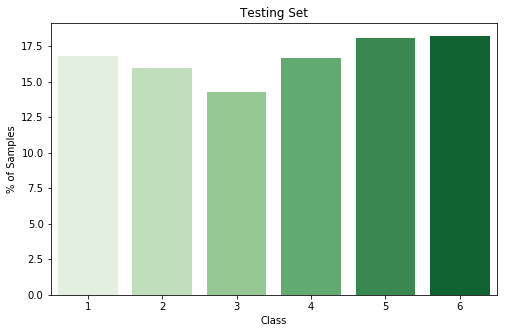

In [0]:
plt.figure(figsize=(8,5))
plt.title("Testing Set")
plt.xlabel("Class")
plt.ylabel("% of Samples")
sns.barplot(np.array(summary_test_set[:,0],dtype=np.int32),summary_test_set[:,2],palette="Greens" )
plt.show()

<h2 style = "color:purple;">Model 1: Neural Network</h2>

In [0]:
def accuracy(pred_labels,true_labels):
    return np.sum((pred_classes-flattened_testY == 0) *1)/pred_labels.shape[0]

In [0]:
# load all train
trainX, trainY = load_dataset('train', 'HARDataset/')
# load all test
testX, testY = load_dataset('test', 'HARDataset/')

In [0]:
flattened_trainX = []

In [0]:
for i in range(trainX.shape[0]):
    flattened_trainX.append(trainX[i].flatten())

In [0]:
flattened_trainX = np.array(flattened_trainX)

In [0]:
flattened_trainY = trainY.flatten()

In [0]:
flattened_trainY.shape

(7352,)

In [0]:
model = Sequential([
    Dense(units=528,input_shape = (128*9,),activation='relu'),
    Dense(units=256,activation='relu'),
    Dense(units=7,activation='softmax',)
])

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 528)               608784    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               135424    
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 1799      
Total params: 746,007
Trainable params: 746,007
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.fit(x=flattened_trainX,y=flattened_trainY,batch_size=20,epochs=25,verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/25
 - 2s - loss: 1.2044 - acc: 0.5528
Epoch 2/25
 - 2s - loss: 0.6711 - acc: 0.7879
Epoch 3/25
 - 2s - loss: 0.4577 - acc: 0.8584
Epoch 4/25
 - 2s - loss: 0.3497 - acc: 0.8909
Epoch 5/25
 - 2s - loss: 0.2804 - acc: 0.9082
Epoch 6/25
 - 2s - loss: 0.2323 - acc: 0.9237
Epoch 7/25
 - 2s - loss: 0.2003 - acc: 0.9340
Epoch 8/25
 - 2s - loss: 0.1772 - acc: 0.9404
Epoch 9/25
 - 2s - loss: 0.1596 - acc: 0.9445
Epoch 10/25
 - 2s - loss: 0.1456 - acc: 0.9489
Epoch 11/25
 - 2s - loss: 0.1352 - acc: 0.9514
Epoch 12/25
 - 2s - loss: 0.1265 - acc: 0.9531
Epoch 13/25
 - 3s - loss: 0.1203 - acc: 0.9539
Epoch 14/25
 - 3s - loss: 0.1158 - acc: 0.9535
Epoch 15/25
 - 2s - loss: 0.1113 - acc: 0.9542
Epoch 16/25
 - 2s - loss: 0.1074 - acc: 0.9557
Epoch 17/25
 - 2s - loss: 0.1045 - acc: 0.9561
Epoch 18/25
 - 2s - loss: 0.1016 - acc: 0.9569
Epoch 19/25
 - 2s - loss: 0.1011 - acc: 0.9581
Epoch 20/25
 - 2s - loss: 0.0977 - acc: 0.9572
Epoch 21/25
 - 2s - l

In [0]:
flattened_testX = []

In [0]:
for i in range(testX.shape[0]):
    flattened_testX.append(testX[i].flatten())

In [0]:
flattened_testX = np.array(flattened_testX)
flattened_testX.shape

(2947, 1152)

In [0]:
flattened_testY = testY.flatten()
flattened_testY.shape

(2947,)

In [0]:
model.evaluate(x=flattened_testX,y=flattened_testY,batch_size=20,verbose=2)

[0.5084983058316386, 0.8856464197494477]

In [0]:
pred_classes = model.predict_classes(x=flattened_testX)
pred_classes

array([5, 5, 5, ..., 2, 2, 2])

In [0]:
accuracy(pred_classes,flattened_testY)

0.8856464200882254

### Training on 128*6

In [0]:
# load all train
trainX, trainY = load_dataset_2('train', 'HARDataset/')
#load all test
testX, testY = load_dataset_2('test', 'HARDataset/')

In [0]:
flattened_trainX = []

In [0]:
for i in range(trainX.shape[0]):
    flattened_trainX.append(trainX[i].flatten())

In [0]:
flattened_trainX = np.array(flattened_trainX)

In [0]:
flattened_trainX.shape

(7352, 768)

In [0]:
flattened_trainY = trainY.flatten()

In [0]:
flattened_trainY.shape

(7352,)

In [0]:
model = Sequential([
    Dense(units=528,input_shape = (128*6,),activation='relu'),
    Dense(units=256,activation='relu'),
    Dense(units=7,activation='softmax',)
])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 528)               406032    
_________________________________________________________________
dense_53 (Dense)             (None, 256)               135424    
_________________________________________________________________
dense_54 (Dense)             (None, 7)                 1799      
Total params: 543,255
Trainable params: 543,255
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.fit(x=flattened_trainX,y=flattened_trainY,batch_size=20,epochs=20,verbose=2)

Epoch 1/20
 - 3s - loss: 0.8585 - acc: 0.5853
Epoch 2/20
 - 2s - loss: 0.5605 - acc: 0.7246
Epoch 3/20
 - 2s - loss: 0.4648 - acc: 0.7916
Epoch 4/20
 - 2s - loss: 0.4114 - acc: 0.8271
Epoch 5/20
 - 2s - loss: 0.3157 - acc: 0.8740
Epoch 6/20
 - 2s - loss: 0.2835 - acc: 0.8913
Epoch 7/20
 - 2s - loss: 0.2132 - acc: 0.9230
Epoch 8/20
 - 2s - loss: 0.1926 - acc: 0.9355
Epoch 9/20
 - 2s - loss: 0.1453 - acc: 0.9484
Epoch 10/20
 - 2s - loss: 0.1409 - acc: 0.9577
Epoch 11/20
 - 2s - loss: 0.1082 - acc: 0.9693
Epoch 12/20
 - 2s - loss: 0.0856 - acc: 0.9733
Epoch 13/20
 - 2s - loss: 0.0831 - acc: 0.9793
Epoch 14/20
 - 2s - loss: 0.0945 - acc: 0.9818
Epoch 15/20
 - 2s - loss: 0.0708 - acc: 0.9830
Epoch 16/20
 - 2s - loss: 0.0768 - acc: 0.9825
Epoch 17/20
 - 2s - loss: 0.0394 - acc: 0.9927
Epoch 18/20
 - 2s - loss: 0.0454 - acc: 0.9925
Epoch 19/20
 - 2s - loss: 0.0172 - acc: 0.9980
Epoch 20/20
 - 2s - loss: 0.0546 - acc: 0.9894


In [0]:
testX.shape

(2947, 128, 6)

In [0]:
testY.shape

(2947, 1)

In [0]:
flattened_testX = []

In [0]:
for i in range(testX.shape[0]):
    flattened_testX.append(testX[i].flatten())

In [0]:
flattened_testX = np.array(flattened_testX)
flattened_testX.shape

(2947, 768)

In [0]:
flattened_testY = testY.flatten()
flattened_testY.shape

(2947,)

In [0]:
model.evaluate(x=flattened_testX,y=flattened_testY,batch_size=20,verbose=2)

[1.0514582624057174, 0.8388191366654798]

In [0]:
pred_classes = model.predict_classes(x=flattened_testX)
pred_classes

array([5, 5, 4, ..., 2, 2, 2])

In [0]:
accuracy(pred_classes,flattened_testY)

0.8388191381065491

### Saving the model 

In [0]:
# Save tf.keras model in HDF5 format.
keras_file = "keras_model.h5"
keras.models.save_model(model,keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.


2174400

<h2 style = "color:purple;">Model 2: Neural Network with normalized data</h2>

### Training on 128*6


In [0]:
# load all train
trainX, trainY = load_dataset_2('train', 'HARDataset/')
#load all test
testX, testY = load_dataset_2('test', 'HARDataset/')

In [0]:
flattened_trainX = []

In [0]:
for i in range(trainX.shape[0]):
    flattened_trainX.append(trainX[i].flatten())

In [0]:
flattened_trainX = np.array(flattened_trainX)

In [0]:
transformer = Normalizer().fit(flattened_trainX)
normalized_trainX = transformer.transform(flattened_trainX)

In [0]:
normalized_trainX.shape

(7352, 768)

In [0]:
print('max:',np.max(normalized_trainX))
print('min:',np.min(normalized_trainX))    

max: 0.6007866295758303
min: -0.47793295754512694


In [0]:
flattened_trainY = trainY.flatten()

In [0]:
flattened_trainY.shape

(7352,)

In [0]:
model = Sequential([
    Dense(units=528,input_shape = (128*6,),activation='relu'),
    Dense(units=256,activation='relu'),
    Dense(units=7,activation='softmax',)
])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 528)               406032    
_________________________________________________________________
dense_59 (Dense)             (None, 256)               135424    
_________________________________________________________________
dense_60 (Dense)             (None, 7)                 1799      
Total params: 543,255
Trainable params: 543,255
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [0]:
model.fit(x=normalized_trainX,y=flattened_trainY,batch_size=20,epochs=10,verbose=2)

Epoch 1/10
 - 3s - loss: 0.9309 - acc: 0.6430
Epoch 2/10
 - 2s - loss: 0.3405 - acc: 0.8772
Epoch 3/10
 - 2s - loss: 0.1824 - acc: 0.9369
Epoch 4/10
 - 2s - loss: 0.1144 - acc: 0.9616
Epoch 5/10
 - 2s - loss: 0.0658 - acc: 0.9797
Epoch 6/10
 - 2s - loss: 0.0506 - acc: 0.9845
Epoch 7/10
 - 2s - loss: 0.0402 - acc: 0.9867
Epoch 8/10
 - 2s - loss: 0.0383 - acc: 0.9865
Epoch 9/10
 - 2s - loss: 0.0288 - acc: 0.9895
Epoch 10/10
 - 2s - loss: 0.0212 - acc: 0.9937


In [0]:
flattened_testX = []

In [0]:
for i in range(testX.shape[0]):
    flattened_testX.append(testX[i].flatten())

In [0]:
flattened_testX = np.array(flattened_testX)
flattened_testX.shape

(2947, 768)

In [0]:
transformer = Normalizer().fit(flattened_testX)
normalized_testX = transformer.transform(flattened_testX)

In [0]:
normalized_testX.shape

(2947, 768)

In [0]:
flattened_testY = testY.flatten()
flattened_testY.shape

(2947,)

In [0]:
model.evaluate(x=normalized_testX,y=flattened_testY,batch_size=20,verbose=2)

[0.6840528767191892, 0.8347471974484185]

In [0]:
pred_classes = model.predict_classes(x=flattened_testX)
pred_classes

array([5, 5, 4, ..., 2, 2, 2])

In [0]:
accuracy(pred_classes,flattened_testY)

0.7889379029521547

<h2 style = "color:purple;">Model 3:Convolutional Neural Network</h2>

In [0]:
def one_hot_encoding(data):
    classes = np.arange(6)
    label=np.ndarray(shape=(data.shape[0],6))
    for i in range(data.shape[0]):
        one_hot  = (classes==data[i]).astype(np.int)
        label[i]=one_hot
    return label

In [0]:
# load all train
trainX, trainY = load_dataset_2('train', 'HARDataset/')

In [0]:
trainX[0].T.shape

(6, 128)

In [0]:
recurrence_trainX = []

## Used recurrence plot suggested by paper to make input 128x128x6

In [0]:
# Recurrence plot transformation
rp = RecurrencePlot(dimension=1, time_delay=1,
                    threshold='percentage_points',
                    percentage=30)
for i in range(trainX.shape[0]):
    recurrence_trainX.append(rp.fit_transform(trainX[i].T))

In [0]:
recurrence_trainX = np.array(recurrence_trainX)

In [0]:
recurrence_trainX[0].T.shape

(128, 128, 6)

In [0]:
model = Sequential()
model.add(Convolution2D(filters=20,kernel_size=(3, 3), input_shape=(6,128,128), data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Convolution2D(filters=20,kernel_size=(3, 3),data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Flatten())
model.add(Dense(units=16820,activation='relu'))
model.add(Dense(units=1000,activation='relu'))
model.add(Dense(units=500,activation='relu'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 20, 126, 126)      1100      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 63, 63)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 20, 61, 61)        3620      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 20, 30, 30)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18000)             0         
_________________________________________________________________
dense_58 (Dense)             (None, 16820)             302776820 
_________________________________________________________________
dense_59 (Dense)             (None, 1000)              16821000  
__________

In [0]:
trainY_altered = trainY - 1 #since our classes start from 1 rather than 0 !!!
trainY_altered[0]

array([4])

In [0]:
one_hot_encodedY = one_hot_encoding(trainY_altered)
one_hot_encodedY[0]

array([0., 0., 0., 0., 1., 0.])

In [0]:
model.fit(x=recurrence_trainX,y=one_hot_encodedY,batch_size=20,epochs=2,verbose=2)

Epoch 1/2


  <h2 style = "color:purple;">Model 4: 1D Convolutional Neural Network</h2>

In [0]:
# load all train
trainX, trainY = load_dataset_2('train', 'HARDataset/')

In [0]:
trainX[0].shape

(128, 6)

In [0]:
trainY_altered = trainY - 1 #since our classes start from 1 rather than 0 !!!
trainY_altered[0]

array([4])

In [0]:
one_hot_encodedY = one_hot_encoding(trainY_altered)
one_hot_encodedY[0]

array([0., 0., 0., 0., 1., 0.])

In [0]:
model = Sequential()
model.add(Conv1D(100, 10, activation='relu', input_shape=(128, 6)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 119, 100)          6100      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 110, 100)          100100    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 36, 100)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 27, 160)           160160    
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 18, 160)           256160    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 160)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 160)               0         
__________

In [0]:
model.fit(x=trainX,y=one_hot_encodedY,batch_size=20,epochs=12,verbose=2)

Epoch 1/12
 - 21s - loss: 0.8302 - acc: 0.5690
Epoch 2/12
 - 19s - loss: 0.6081 - acc: 0.6733
Epoch 3/12
 - 20s - loss: 0.5151 - acc: 0.7500
Epoch 4/12
 - 19s - loss: 0.3925 - acc: 0.8317
Epoch 5/12
 - 19s - loss: 0.3479 - acc: 0.8621
Epoch 6/12
 - 19s - loss: 0.2901 - acc: 0.8851
Epoch 7/12
 - 19s - loss: 0.2604 - acc: 0.8954
Epoch 8/12
 - 19s - loss: 0.2684 - acc: 0.8993
Epoch 9/12
 - 19s - loss: 0.2410 - acc: 0.9106
Epoch 10/12
 - 20s - loss: 0.2122 - acc: 0.9203
Epoch 11/12
 - 19s - loss: 0.1929 - acc: 0.9255
Epoch 12/12
 - 19s - loss: 0.2086 - acc: 0.9251


In [0]:
#load all test
testX, testY = load_dataset_2('test', 'HARDataset/')

In [0]:
testX[0].shape

(128, 6)

In [0]:
testY_altered = testY - 1 #since our classes start from 1 rather than 0 !!!
testY_altered[0]

array([4])

In [0]:
one_hot_encodedY = one_hot_encoding(testY_altered)
one_hot_encodedY[0]

array([0., 0., 0., 0., 1., 0.])

In [0]:
model.evaluate(x=testX,y=one_hot_encodedY,batch_size=20,verbose=2) #loss and accuracy

[0.5753766069435932, 0.8771632140901156]

### Saving the model 

In [0]:
# Save tf.keras model in HDF5 format.
keras_file = "keras_model_cnn.h5"
keras.models.save_model(model,keras_file)

# Convert to TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model_file(keras_file)
tflite_model = converter.convert()
open("converted_model_cnn.tflite", "wb").write(tflite_model)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.


2097792

  <h2 style = "color:purple;">Model 5: 1D Convolutional Neural Network with normalized data</h2>


In [0]:
# load all train
trainX, trainY = load_dataset_2('train', 'HARDataset/')

In [0]:
trainX.shape

(7352, 128, 6)

In [0]:
normalized_trainX = []
for i in range(trainX.shape[0]):
    transformer = Normalizer().fit(trainX[i])
    norm_X = transformer.transform(trainX[i])
    normalized_trainX.append(norm_X)

In [0]:
normalized_trainX = np.array(normalized_trainX)

In [0]:
normalized_trainX.shape

(7352, 128, 6)

In [0]:
print('min:',np.min(normalized_trainX))
print('max:',np.max(normalized_trainX))

min: -0.9995361747283659
max: 0.999524597826774


In [0]:
trainY_altered = trainY - 1 #since our classes start from 1 rather than 0 !!!
trainY_altered[0]

array([4])

In [0]:
one_hot_encodedY = one_hot_encoding(trainY_altered)
one_hot_encodedY[0]

array([0., 0., 0., 0., 1., 0.])

In [0]:
model = Sequential()
model.add(Conv1D(100, 10, activation='relu', input_shape=(128, 6)))
model.add(Conv1D(100, 10, activation='relu'))
model.add(MaxPooling1D(3))
model.add(Conv1D(160, 10, activation='relu'))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr = 0.001),
              metrics=['accuracy'])

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 119, 100)          6100      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 110, 100)          100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 36, 100)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 27, 160)           160160    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 18, 160)           256160    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 160)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 160)               0         
__________

In [0]:
model.fit(x=normalized_trainX,y=one_hot_encodedY,batch_size=20,epochs=10,verbose=2)

Epoch 1/10
 - 22s - loss: 0.7631 - acc: 0.6828
Epoch 2/10
 - 19s - loss: 0.3496 - acc: 0.8765
Epoch 3/10
 - 20s - loss: 0.2556 - acc: 0.9102
Epoch 4/10
 - 20s - loss: 0.2187 - acc: 0.9184
Epoch 5/10
 - 18s - loss: 0.1729 - acc: 0.9380
Epoch 6/10
 - 18s - loss: 0.1620 - acc: 0.9419
Epoch 7/10
 - 18s - loss: 0.1411 - acc: 0.9489
Epoch 8/10
 - 18s - loss: 0.1451 - acc: 0.9498
Epoch 9/10
 - 19s - loss: 0.1342 - acc: 0.9516
Epoch 10/10
 - 19s - loss: 0.0965 - acc: 0.9676


In [0]:
#load all test
testX, testY = load_dataset_2('test', 'HARDataset/')

In [0]:
testX[0].shape

(128, 6)

In [0]:
normalized_testX = []
for i in range(testX.shape[0]):
    transformer = Normalizer().fit(testX[i])
    norm_X = transformer.transform(testX[i])
    normalized_testX.append(norm_X)

In [0]:
normalized_testX = np.array(normalized_testX)

In [0]:
testY_altered = testY - 1 #since our classes start from 1 rather than 0 !!!
testY_altered[0]

array([4])

In [0]:
one_hot_encodedY = one_hot_encoding(testY_altered)
one_hot_encodedY[0]

array([0., 0., 0., 0., 1., 0.])

In [0]:
model.evaluate(x=normalized_testX,y=one_hot_encodedY,batch_size=20,verbose=2) #loss and accuracy

[0.3139856550524486, 0.9168646052444349]